In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import concurrent.futures
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [3]:
# Adjust these paths to your dataset and output folder
BASE_PATH = "../dataset/CCPD2019"
#BASE_PATH = "../dataset/xx"
#BASE_OUTPUT_PATH = "../dataset/preprocessed"
BASE_OUTPUT_PATH = "../preprocessed_presorted"
os.makedirs(BASE_OUTPUT_PATH, exist_ok=True)

## Calculate Coverage

In [4]:
def parse_filename(filename: str) -> np.array:
    '''Extract ground truth coordinates from filename

    :param filename: The filename of the image.
    :return: The bounding box coordinates of the license plate.
    '''
    parts = filename.split('-')
    try:
        # Get bounding box coordinates
        bbox = parts[3].split('_')

        bbox = [vertex.split('&') for vertex in bbox]

        xa = int(bbox[0][0])
        ya = int(bbox[0][1])
        xb = int(bbox[1][0])
        yb = int(bbox[1][1])
        xc = int(bbox[2][0])
        yc = int(bbox[2][1])
        xd = int(bbox[3][0])
        yd = int(bbox[3][1])

        return np.array([[xb, yb], [xa, ya], [xd, yd], [xc, yc]], dtype=np.int32)

    except:
        return None

In [5]:
def calculate_overlap_percentage(green_box: np.array, label_box: np.array) -> float:
    '''
    Calculates the percentage of how much of the actual license plate (exact coordinates from the image filename) is located inside the green box.
    The green box is the bounding box that is detected by the HSV pipeline.
    The label box is the bounding box that is from the image filename.

    :param green_box: np.array of shape (4,2) representing the corners of the green box.
    :param label_box: np.array of shape (4,2) representing the corners of the label box.
    :return: Percentage of the label box inside the green box.
    '''
    # Convert to shapely polygons
    green_poly = Polygon(green_box)
    label_poly = Polygon(label_box)

    # Calculate intersection area
    intersection = green_poly.intersection(label_poly).area

    # Calculate label box area
    label_area = label_poly.area

    if label_area == 0:  # Avoid division by zero
        return 0.0

    # Compute percentage of label box inside the green box
    return (intersection / label_area) * 100

## HSV Pipeline

In [6]:
def update_filename(filename: str) -> str:
    '''
    Set the license plate number in the filename to "33_24_34_34_34_34_34",
    this is the format of the license plate number in the dataset.
    "33_24_34_34_34_34_34" is decoded as "O_O_O_O_O_O_O".
    The character "O" in the dataset is used as a sign for "no character" because there is no O in Chinese license plate characters.

    :param filename: The filename of the image.
    :return: The filename with the license plate number set to "O_O_O_O_O_O_O".
    '''

    parts = filename.split('-')
    parts[4] = "33_24_34_34_34_34_34"
    return "-".join(parts)

In [7]:
def display_results(image, mask, output_image, plate_region):
    '''Display results'''
    fig, ax = plt.subplots(1, 4, figsize=(20, 8))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Blue Mask")

    ax[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Detected License Plate")

    ax[3].imshow(cv2.cvtColor(plate_region, cv2.COLOR_BGR2RGB))
    ax[3].set_title("Image region")

    for a in ax:
        a.axis("off")

    plt.show()

In [8]:
def HSV_function(filename: str, LOWER_BLUE: np.array, UPPER_BLUE: np.array, partition_folder: str):
    '''
    This function is used to preprocess the images in the dataset.
    It takes an image, tries to detect the license plate, and saves the cropped license plate at the specified output folder.
    It returns the accuracy of the detection.
    '''

    # Load image
    if partition_folder:
        IMAGE_PATH = f"{BASE_PATH}/{partition_folder}/images/{filename}"
    else:
        IMAGE_PATH = f"{BASE_PATH}/{filename}"

    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print("Error: Could not load image. Check the file path.")
        exit()

    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply thresholding to detect blue regions
    mask_blue = cv2.inRange(hsv, LOWER_BLUE, UPPER_BLUE)

    # Try different kernel sizes
    kernel_sizes = [(5, 5), (3, 3), (7, 7)]
    for kernel_size in kernel_sizes:
        # Apply morphological operations to clean up the mask
        kernel = np.ones((7, 7), np.uint8)
        mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel, iterations = 2)  # Close small holes
        kernel = np.ones(kernel_size, np.uint8)
        mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)  # Remove noise

        # Find contours in the mask
        contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set aspect ratio range for license plates
        MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio
        MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio
        MIN_AREA = 18000  # Minimum area to ignore small objects
        MAX_AREA = 170000  # Maximum area to ignore large objects

        best_plate = None
        max_area = 0  # Track the largest detected plate

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate aspect ratio (width / height)
            aspect_ratio = w / float(h)

            # Calculate contour area
            area = cv2.contourArea(contour)

            # Check if the detected contour matches a plate's expected shape
            if MIN_ASPECT_RATIO < aspect_ratio < MAX_ASPECT_RATIO and area > MIN_AREA and area < MAX_AREA:
                if area > max_area:  # Keep the largest valid plate
                    max_area = area
                    best_plate = (x, y, w, h)

        # Draw detected license plate
        output_image = image.copy()
        if best_plate:
            x, y, w, h = best_plate

            # Expand the detected plate region to prevent cutting off the plate
            x = max((x - int(w*0.15)), 0)
            y = max((y - int(h*0.1)), 0)
            w = (w + 2 * int(w*0.15))
            h = (h + 2 * int(h*0.1))

            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 4)  # Green rectangle around plate

            green_box = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])

            box_from_filename = parse_filename(filename)

            label_box = box_from_filename.reshape((-1, 1, 2))
            cv2.polylines(output_image, [label_box], isClosed=True, color=(0, 0, 255), thickness=4)   # Red rectangle from filename

            plate_region = image[y:y+h, x:x+w]  # Extract the detected plate

            accuracy = calculate_overlap_percentage(green_box, box_from_filename)

            if accuracy == 0:
                accuracy = 1
        else:
            plate_region = None
            accuracy = 0

        if best_plate:
            if plate_region is not None:
                if accuracy < 20:
                    # Save with updated filename, this is the filename with the license plate number set to "O_O_O_O_O_O_O" -> "no characters"
                    plate_path = os.path.join(BASE_OUTPUT_PATH, f"{update_filename(filename)}")
                else:
                    # Save cropped plate region
                    plate_path = os.path.join(BASE_OUTPUT_PATH, f"{filename}")
                cv2.imwrite(plate_path, plate_region)

            # display_results(image, mask, output_image, plate_region)

    return accuracy

In [9]:
# stats

def plot_histogram(data: np.array):
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=20, edgecolor="black", alpha=0.75)
    plt.xlabel("Accuracy Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accuracy Scores")
    plt.grid(True)
    plt.show()

def plot_pie_chart(correct_count: int, total_count: int):
    incorrect_count = total_count - correct_count
    labels = ['Plate Found', 'No Plate Found']
    sizes = [correct_count, incorrect_count]
    colors = ['#4CAF50', '#FF5733']  # Green and red

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, shadow=False)
    plt.title("Plate Found vs No Plate Found")
    plt.show()

def plot_pie_chart2(correct_count: int, total_count: int):
    incorrect_count = total_count - correct_count
    labels = ['Correct Prediction (> 90%)', 'Found Plate is Wrong']
    sizes = [correct_count, incorrect_count]
    colors = ['#4CAF50', '#FF5733']  # Green and red

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, shadow=False)
    plt.title("Correct Prediction (> 90%) vs Found Plate is Wrong")
    plt.show()

In [12]:
def HSV_pipeline(filename: str, partition_folder: str):
    '''
    Runs an image through the HSV pipeline and returns the accuracy of the detection.
    The HSV pipeline tries to detect the license plate by using different HSV ranges, the image is run through a max. of 5 different HSV ranges.
    If the accuracy is 0, no license plate contour is detected.

    :param filename: The filename of the image.
    :param partition_folder: The folder of the image.
    :return: The accuracy of the detection, percentage of how much of the actual license plate (exact coordinates from the image filename) is located inside the green box.
    '''

    OUTPUT_PATH = f"{BASE_OUTPUT_PATH}"

    # Define the optimized HSV range for blue plates
    LOWER_BLUE = np.array([89, 125, 126])
    UPPER_BLUE = np.array([124, 255, 255])
    accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE, partition_folder)

    # Create output directory if not exists
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    if accuracy == 0:
        LOWER_BLUE = np.array([100, 70, 70])
        UPPER_BLUE = np.array([130, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE, partition_folder)

    if accuracy == 0:
        LOWER_BLUE = np.array([84, 36, 56])
        UPPER_BLUE = np.array([165, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE, partition_folder)

    if accuracy == 0:
        LOWER_BLUE = np.array([67, 64, 70])
        UPPER_BLUE = np.array([180, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE, partition_folder)

    if accuracy == 0:
        LOWER_BLUE = np.array([81, 118, 52])
        UPPER_BLUE = np.array([176, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE, partition_folder)

    return accuracy

def preprocess_images(partition_folder: str = None):
    '''
    Preprocesses the images in the dataset.
    It runs the HSV pipeline on each image and saves the cropped license plate at the specified output folder.
    It returns the accuracy of the detection.

    :param partition_folder: The folder of the image.
    :return: All accuracies, array with the accuracy of each image.
    '''

    accuracies= []

    if partition_folder:
        path = f"{BASE_PATH}/{partition_folder}"

        with open(f"{path}/file_names.txt", "r") as file:
            lines = file.readlines()

        # Use ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor() as executor:
            accuracies = list(executor.map(lambda filename: HSV_pipeline(filename.strip(), partition_folder), lines))
    else:
        for partition_folder in ["test", "train", "val"]:
            path = f"{BASE_PATH}/{partition_folder}"

            with open(f"{path}/file_names.txt", "r") as file:
                lines = file.readlines()

            # Use ThreadPoolExecutor for parallel execution
            with concurrent.futures.ThreadPoolExecutor() as executor:
                accuracies += list(executor.map(lambda filename: HSV_pipeline(filename.strip(), partition_folder), lines))

    data = np.array(accuracies)

    plot_histogram(data)

    mean = np.mean(data)
    count = np.count_nonzero(data)

    plot_pie_chart(count, len(data))
    plot_pie_chart2(np.sum(data > 90), count)

    print(f"Count 1: {np.sum(data == 1)}")

    print(f"Overall Mean: {mean}")
    print(f"Overall Count: {count}")

    print("Correctness_score_above_zero: ", sum(data)/count)
    print(f"Correctness score above 1: {np.sum(data > 1)/(count - np.sum(data == 1))}")
    print("Overall Correct: ", count/len(data))
    return data

## Test Runs

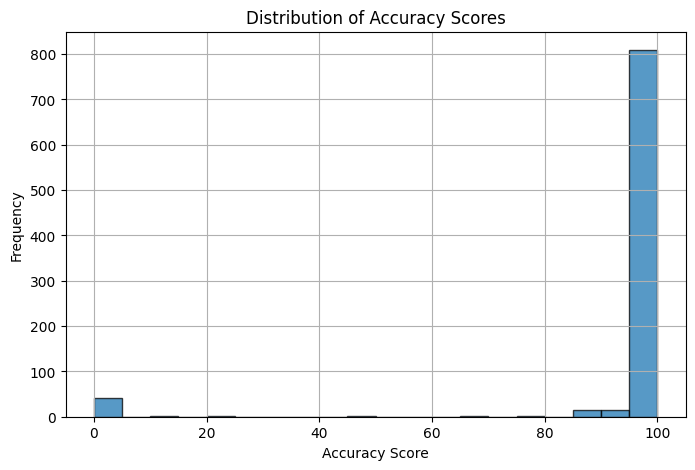

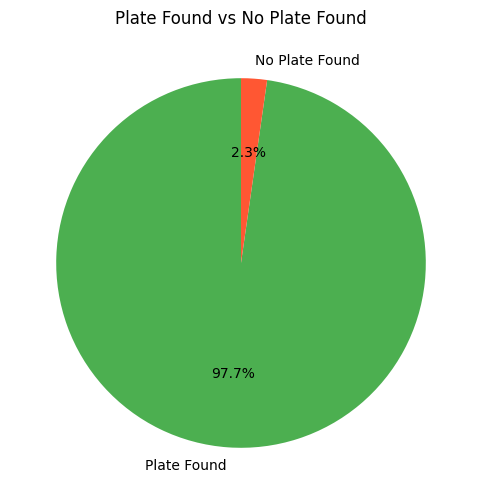

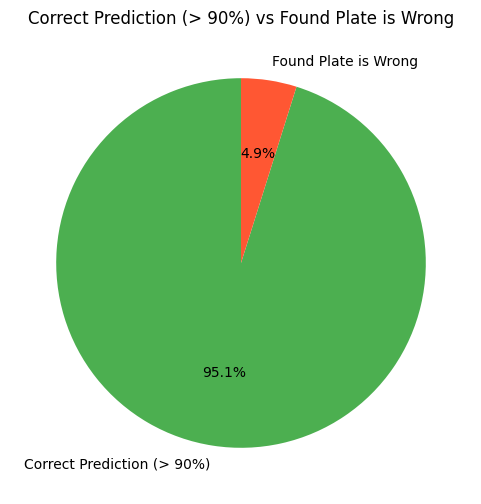

Count 1: 21
Overall Mean: 94.44659201694077
Overall Count: 865
Correctness_score_above_zero:  96.63032824854623
Correctness score above 1: 0.9988151658767772
Overall Correct:  0.9774011299435028


In [14]:
accuracy = preprocess_images()

Train: 


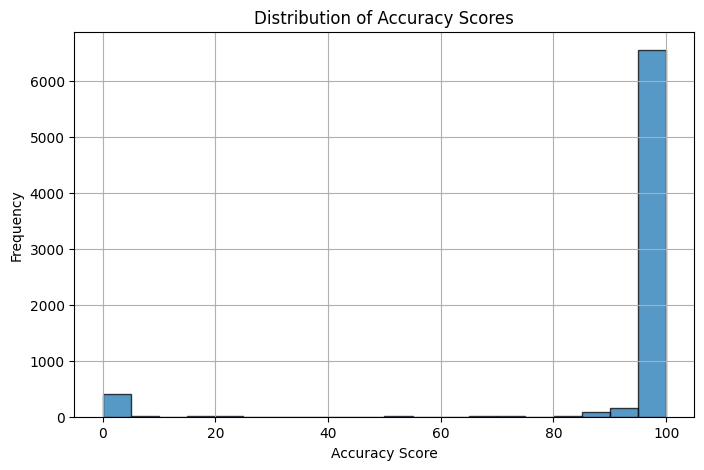

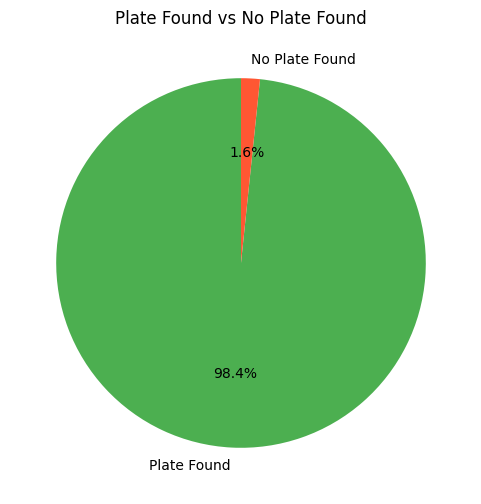

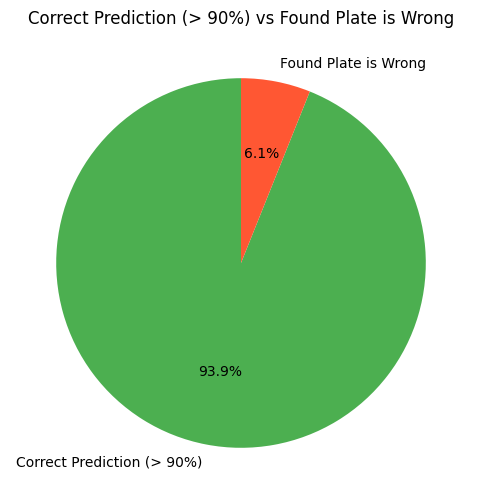

Count 1: 279
Overall Mean: 93.59483631371346
Overall Count: 7129
Correctness_score_above_zero:  95.15715718919832
Correctness score above 1: 0.9992700729927008
Overall Correct:  0.9835816777041942
[  1.          99.68793343 100.         ... 100.          99.95304278
 100.        ]
Val: 


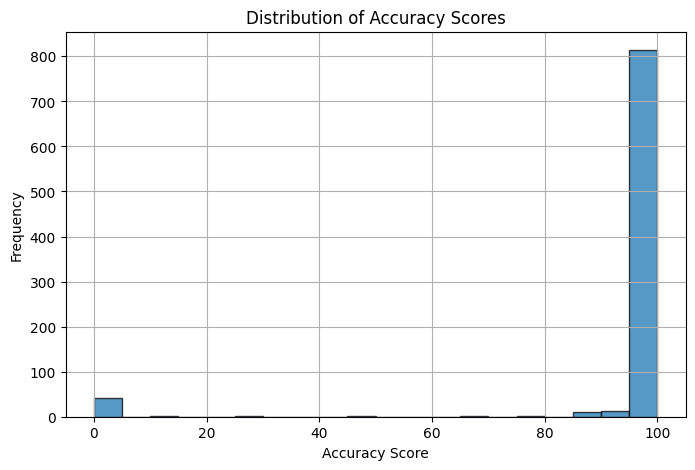

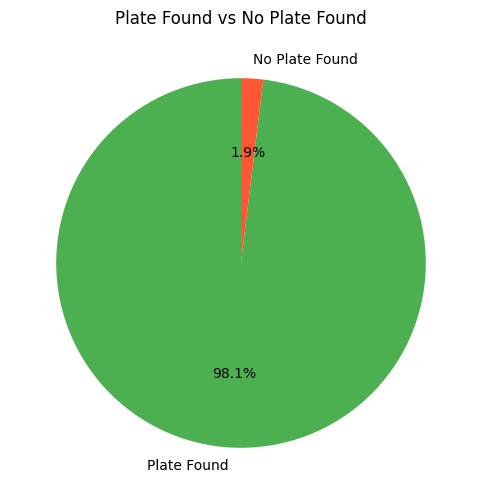

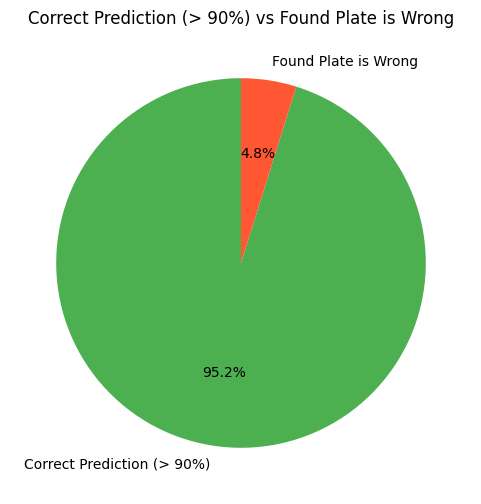

Count 1: 24
Overall Mean: 94.50288425076545
Overall Count: 868
Correctness_score_above_zero:  96.35374719116064
Correctness score above 1: 0.9988151658767772
Overall Correct:  0.9807909604519774
[1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 9.98670213e+01 1.00000000e+02 9.99793814e+01 1.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.88277512e+01 9.92177722e+01 9.99693627e+01
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.19047619e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.85725615e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.68587747e+01 1.00000000e+02
 1.00000000e+02 9.89864865e+01 1.00000000e+02 9.99540863e+01
 1.00000000e+02 9.93818681e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.96732026e+01 1.00000000e+02 1.00000000e+02
 1.00000000e

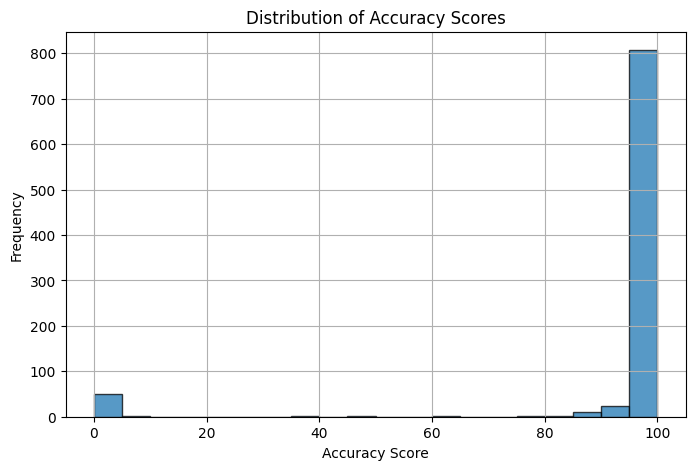

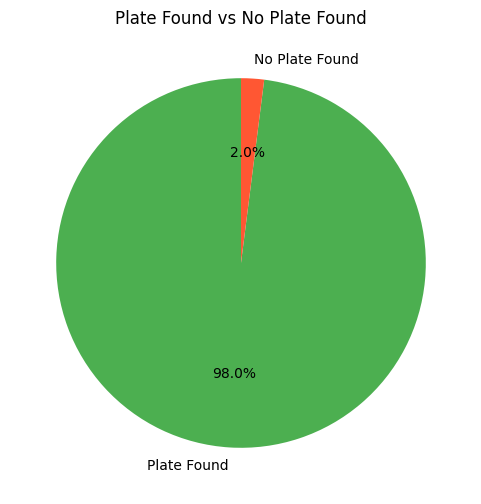

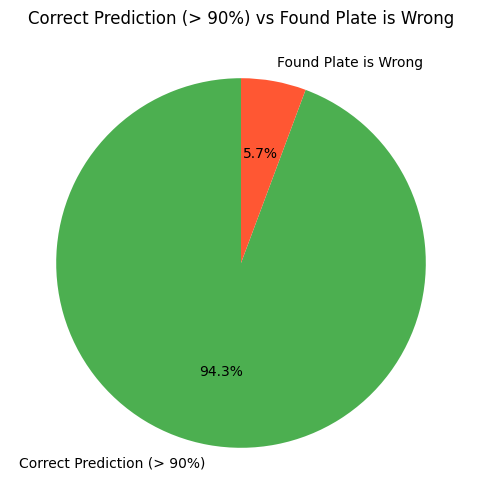

Count 1: 32
Overall Mean: 93.55742602828141
Overall Count: 880
Correctness_score_above_zero:  95.4711006515872
Correctness score above 1: 1.0
Overall Correct:  0.9799554565701559
[ 99.75490196 100.          99.93686869 100.         100.
 100.         100.         100.           1.          91.41509434
  99.97311828 100.          99.74747475 100.          99.75490196
 100.          99.9599359  100.         100.         100.
 100.         100.         100.         100.         100.
  99.48453608 100.         100.         100.         100.
 100.         100.         100.         100.          99.71537002
 100.         100.         100.         100.         100.
 100.          99.9599359  100.         100.          88.82833787
 100.         100.         100.         100.         100.
  96.61363636 100.         100.          94.87234043 100.
  99.93131868  99.90004998  99.91666667 100.           7.70687646
 100.          99.11111111   1.         100.          99.95951417
 100.         100. 

In [129]:
print("Train: ")
accuracy_train = preprocess_images("train")

print("Val: ")
accuracy_val = preprocess_images("val")

print("Test: ")
accuracy_test = preprocess_images("test")

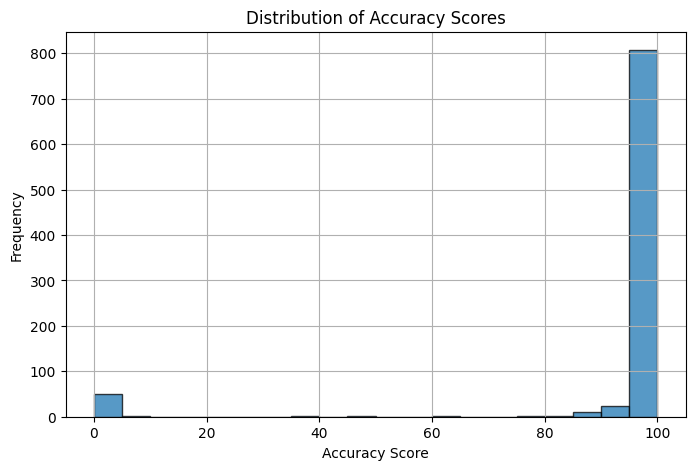

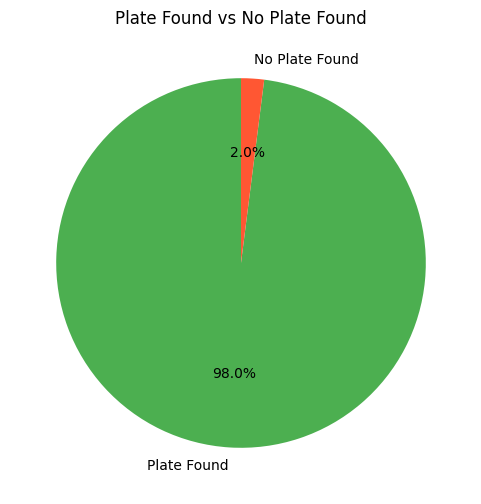

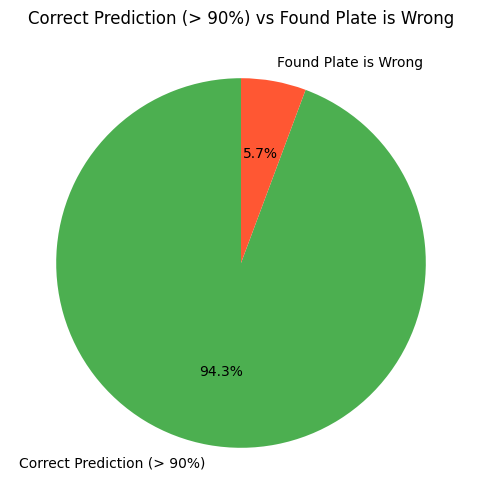

Count 1: 32
Overall Mean: 93.55742602828141
Overall Count: 880
Correctness_score_above_zero:  95.4711006515872
Correctness score above 1: 1.0
Overall Correct:  0.9799554565701559
[ 99.75490196 100.          99.93686869 100.         100.
 100.         100.         100.           1.          91.41509434
  99.97311828 100.          99.74747475 100.          99.75490196
 100.          99.9599359  100.         100.         100.
 100.         100.         100.         100.         100.
  99.48453608 100.         100.         100.         100.
 100.         100.         100.         100.          99.71537002
 100.         100.         100.         100.         100.
 100.          99.9599359  100.         100.          88.82833787
 100.         100.         100.         100.         100.
  96.61363636 100.         100.          94.87234043 100.
  99.93131868  99.90004998  99.91666667 100.           7.70687646
 100.          99.11111111   1.         100.          99.95951417
 100.         100. 

In [119]:
preprocess_images("test")

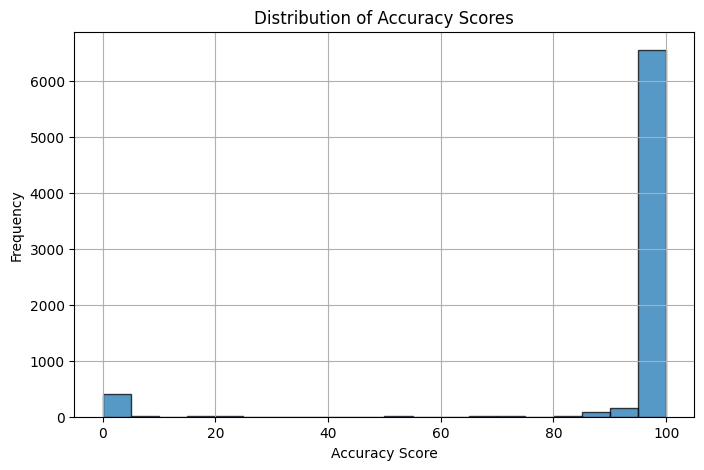

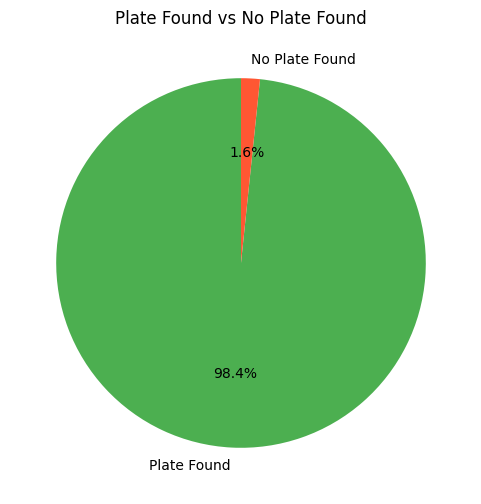

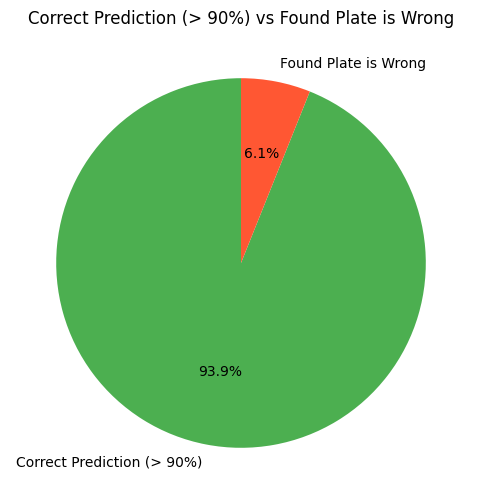

Count 1: 279
Overall Mean: 93.59483631371346
Overall Count: 7129
Correctness_score_above_zero:  95.15715718919832
Correctness score above 1: 0.9992700729927008
Overall Correct:  0.9835816777041942
[  1.          99.68793343 100.         ... 100.          99.95304278
 100.        ]


In [118]:
preprocess_images("train")

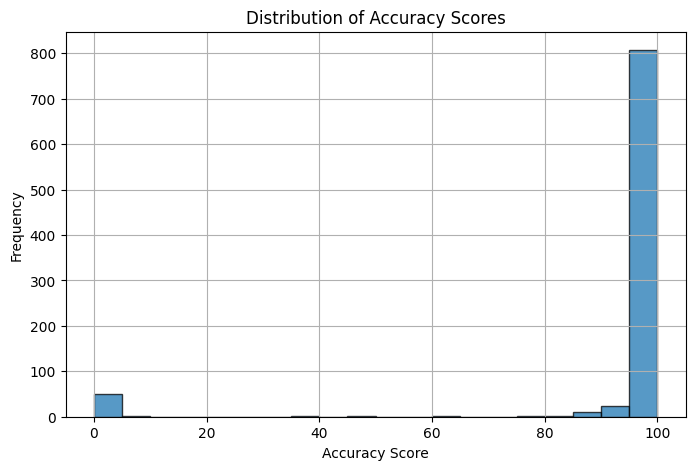

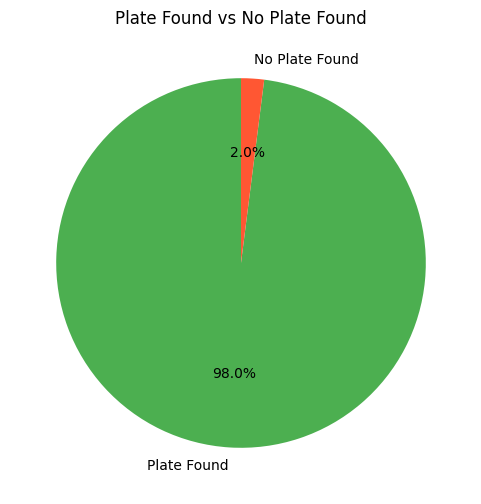

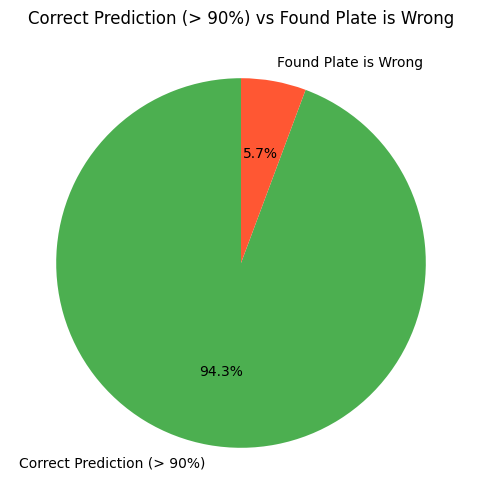

Count 1: 32
Overall Mean: 93.55742602828141
Overall Count: 880
Correctness_score_above_zero:  95.4711006515872
Correctness score above 1: 1.0
Overall Correct:  0.9799554565701559
[ 99.75490196 100.          99.93686869 100.         100.
 100.         100.         100.           1.          91.41509434
  99.97311828 100.          99.74747475 100.          99.75490196
 100.          99.9599359  100.         100.         100.
 100.         100.         100.         100.         100.
  99.48453608 100.         100.         100.         100.
 100.         100.         100.         100.          99.71537002
 100.         100.         100.         100.         100.
 100.          99.9599359  100.         100.          88.82833787
 100.         100.         100.         100.         100.
  96.61363636 100.         100.          94.87234043 100.
  99.93131868  99.90004998  99.91666667 100.           7.70687646
 100.          99.11111111   1.         100.          99.95951417
 100.         100. 

In [114]:
preprocess_images("test")

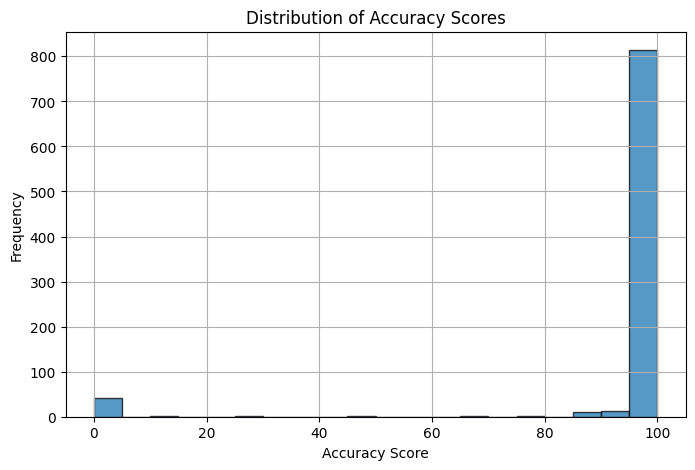

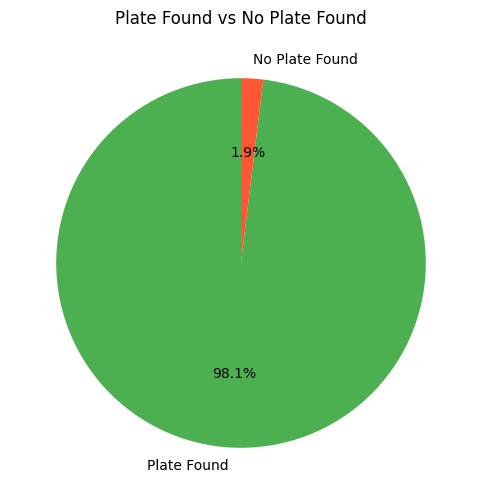

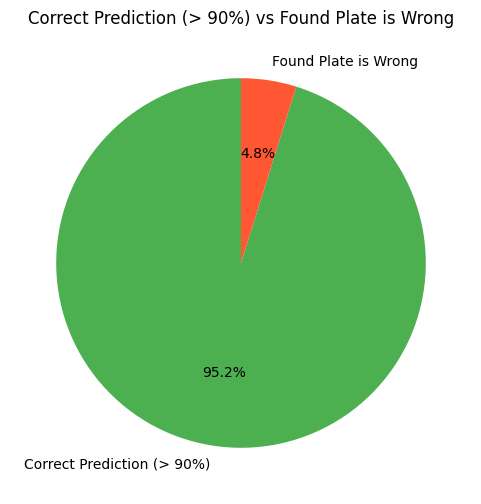

Count 1: 24
Overall Mean: 94.50288425076545
Overall Count: 868
Correctness_score_above_zero:  96.35374719116064
Correctness score above 1: 0.9988151658767772
Overall Correct:  0.9807909604519774
[1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 9.98670213e+01 1.00000000e+02 9.99793814e+01 1.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.88277512e+01 9.92177722e+01 9.99693627e+01
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.19047619e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.85725615e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.68587747e+01 1.00000000e+02
 1.00000000e+02 9.89864865e+01 1.00000000e+02 9.99540863e+01
 1.00000000e+02 9.93818681e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.96732026e+01 1.00000000e+02 1.00000000e+02
 1.00000000e

In [111]:
preprocess_images("val")

# make the cropped region wider
            # x = max((x - int(w*0.15)), 0)
            # y = max((y - int(h*0.1)), 0)
            # w = (w + 2 * int(w*0.15))
            # h = (h + 2 * int(h*0.1))

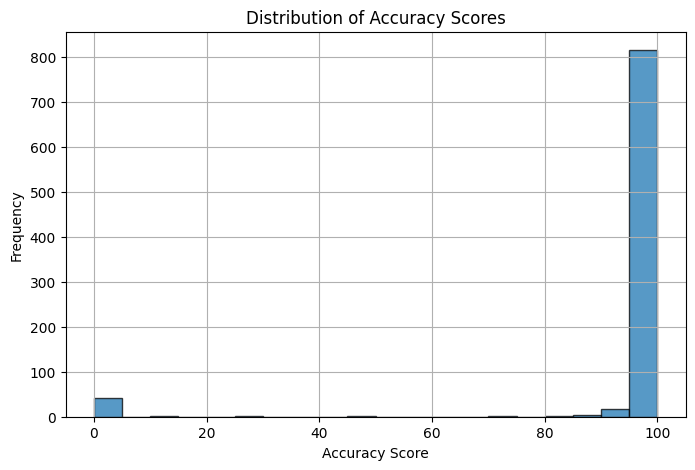

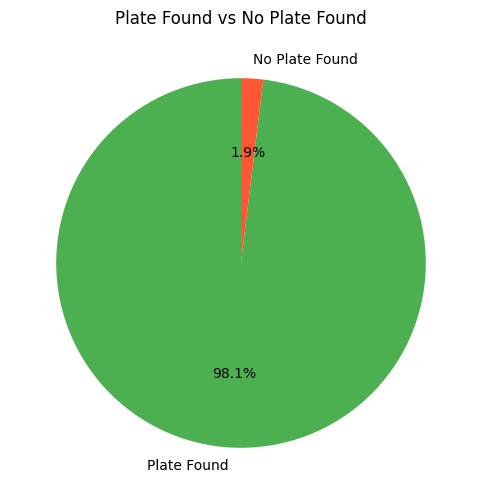

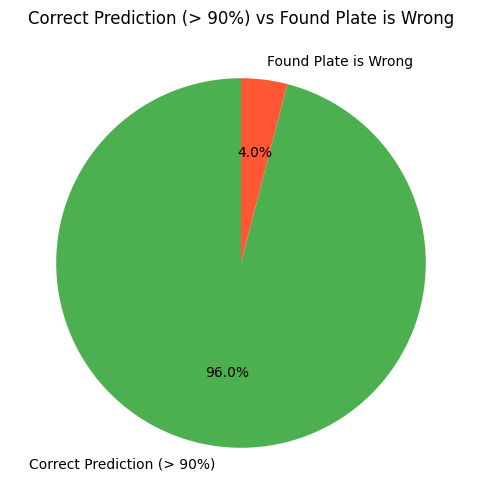

Count 1: 24
Overall Mean: 94.56235893354393
Overall Count: 868
Correctness_score_above_zero:  96.41438670067551
Correctness score above 1: 0.9988151658767772
Overall Correct:  0.9807909604519774
[1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 9.98670213e+01 1.00000000e+02 9.99793814e+01 1.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.88277512e+01 9.92177722e+01 9.99693627e+01
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.19047619e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.85725615e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.68587747e+01 1.00000000e+02
 1.00000000e+02 9.89864865e+01 1.00000000e+02 9.99540863e+01
 1.00000000e+02 9.93818681e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 9.96732026e+01 1.00000000e+02 1.00000000e+02
 1.00000000e

In [109]:
preprocess_images("val")
# with box adjustment, bigger kernel and 2x closing iterations

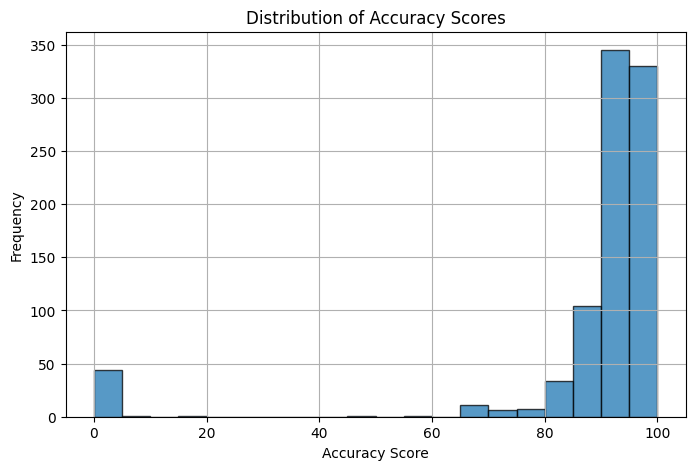

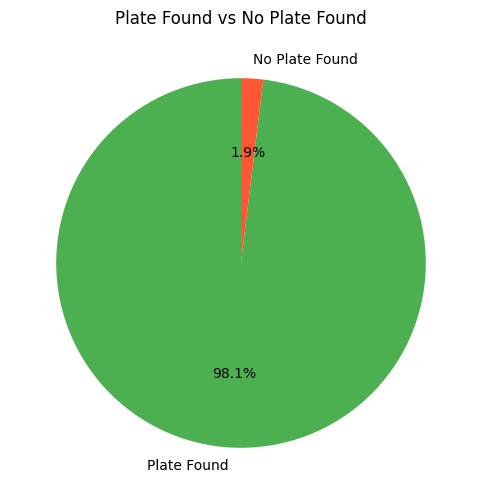

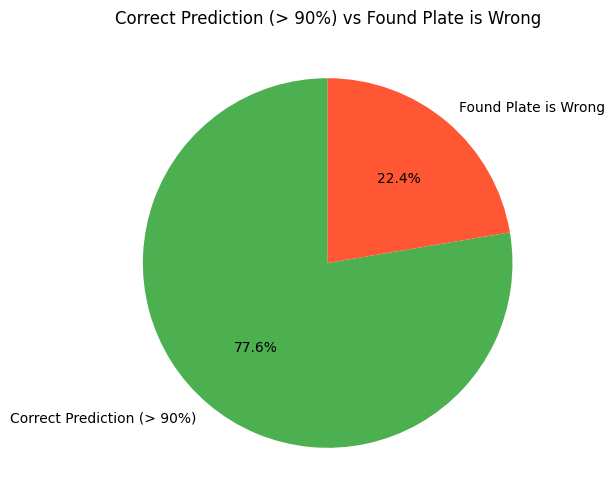

Count 1: 27
Overall Mean: 88.0759108870387
Overall Count: 868
Correctness_score_above_zero:  89.80089992514903
Correctness score above 1: 1.0
Overall Correct:  0.9807909604519774
[ 98.54216867  95.01727439  91.90588235  94.55375346  89.78629188
  93.28902033  96.54441067  97.07932396  89.67865104  97.57754023
  95.08985264   1.          98.05858727  86.54230201  94.40613027
  91.25353666  95.64024982   1.          91.09153153  97.20507597
 100.          89.9005095   90.48190074  93.98290291  98.30909318
  97.57834758 100.          94.50047719  94.96883541  91.35357992
  78.58649789  94.28615651 100.          96.65861514  87.41002315
  94.54062838  89.55621572  94.59755856  86.04629114  90.82083647
  95.49652635  85.2175312   97.07446945  93.08677095  98.79896526
  84.16015141  99.63099631  95.10957967  95.89911007  90.96532486
  96.38999179  99.14675768  99.62789987  96.23594112  96.34436719
  94.12332262  94.80499512  94.10907693 100.          91.72006368
  91.52988703  95.9136273   9

In [106]:
preprocess_images("val")
# use bigger closing kernel (7, 7)

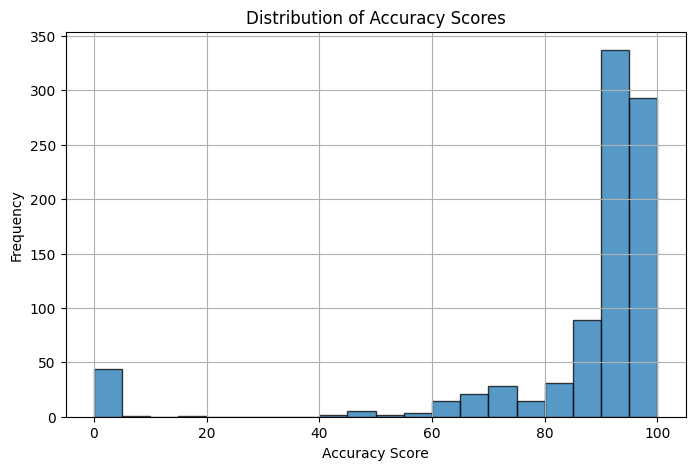

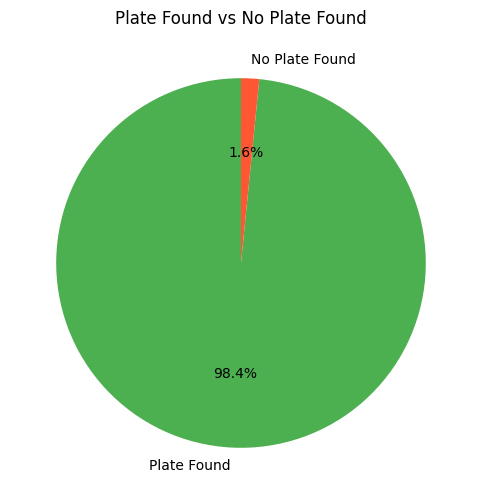

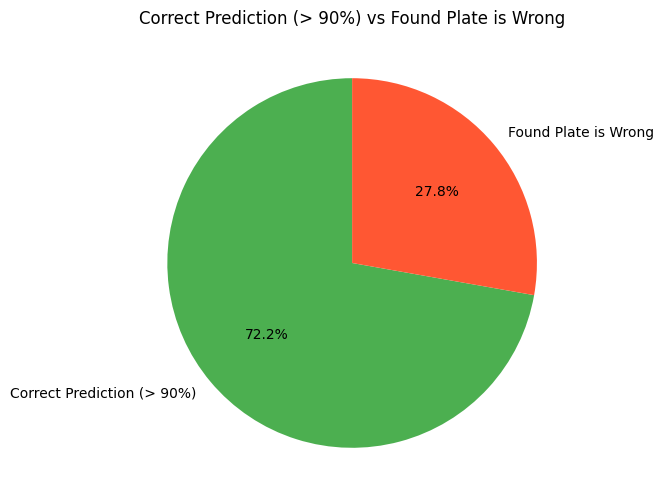

Count 1: 30
Overall Mean: 86.1055550074661
Overall Count: 871
Correctness_score_above_zero:  87.48957081700065
Correctness score above 1: 1.0
Overall Correct:  0.984180790960452
[ 98.54216867  95.01727439  91.90588235  94.55375346  84.79058814
  93.28902033  96.54441067  97.07932396  89.67865104  97.42935882
  94.44358313   1.          98.05858727  86.54230201  94.40613027
  91.25353666  95.64024982  96.93625318  91.09153153  97.20507597
  99.9000999   88.1941624   90.48190074  92.94730459  98.30909318
   0.          63.53171525  94.50047719  94.96883541  91.35357992
  74.88830975  72.94237828 100.          96.65861514  87.41002315
  94.54062838  89.55621572  94.59755856  86.04629114  90.82083647
  95.49652635  84.46442561  72.96051528  93.08677095  97.31506891
  84.16015141  99.26180535  95.10957967  95.89911007  90.96532486
  96.17378016  99.14675768  99.62789987  96.23594112  96.34436719
  94.12332262  94.80499512  94.10907693 100.          91.72006368
  91.52988703  95.9136273   91

In [104]:
preprocess_images("val")


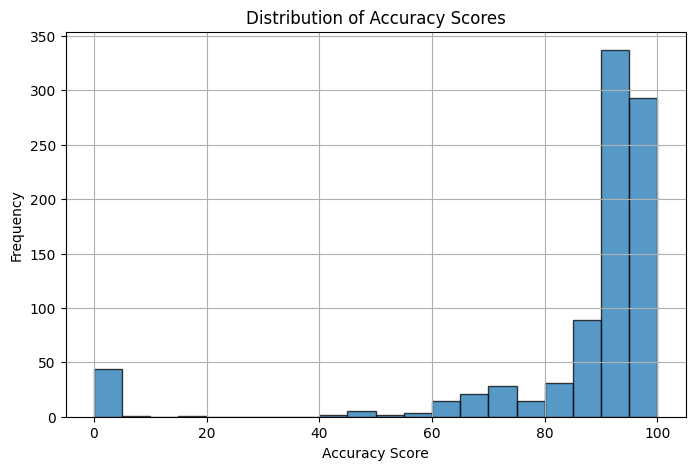

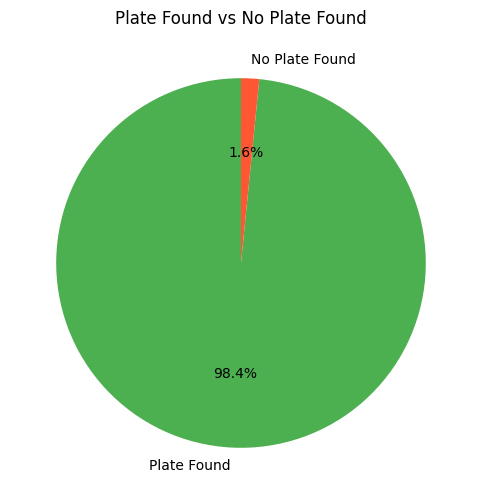

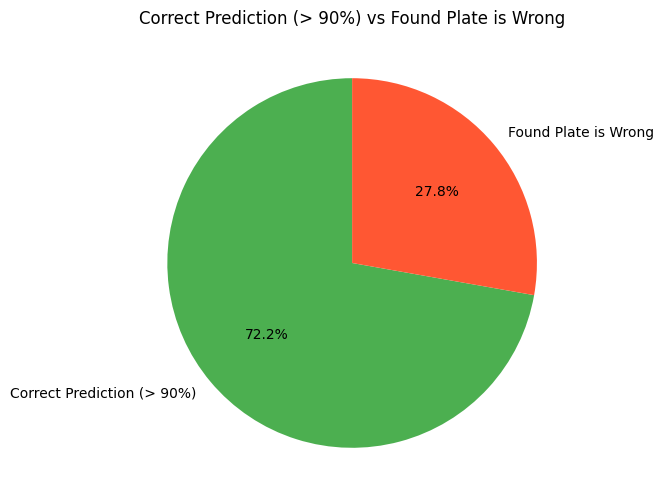

Count 1: 30
Overall Mean: 86.1055550074661
Overall Count: 871
Correctness_score_above_zero:  87.48957081700065
Correctness score above 1: 1.0
Overall Correct:  0.984180790960452
[ 98.54216867  95.01727439  91.90588235  94.55375346  84.79058814
  93.28902033  96.54441067  97.07932396  89.67865104  97.42935882
  94.44358313   1.          98.05858727  86.54230201  94.40613027
  91.25353666  95.64024982  96.93625318  91.09153153  97.20507597
  99.9000999   88.1941624   90.48190074  92.94730459  98.30909318
   0.          63.53171525  94.50047719  94.96883541  91.35357992
  74.88830975  72.94237828 100.          96.65861514  87.41002315
  94.54062838  89.55621572  94.59755856  86.04629114  90.82083647
  95.49652635  84.46442561  72.96051528  93.08677095  97.31506891
  84.16015141  99.26180535  95.10957967  95.89911007  90.96532486
  96.17378016  99.14675768  99.62789987  96.23594112  96.34436719
  94.12332262  94.80499512  94.10907693 100.          91.72006368
  91.52988703  95.9136273   91

In [100]:
preprocess_images("val")
# ohne anpassung der green box
# fill holes iterations = 2

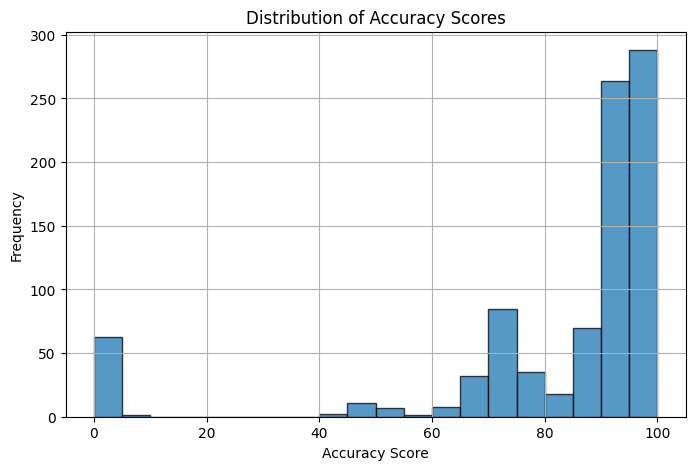

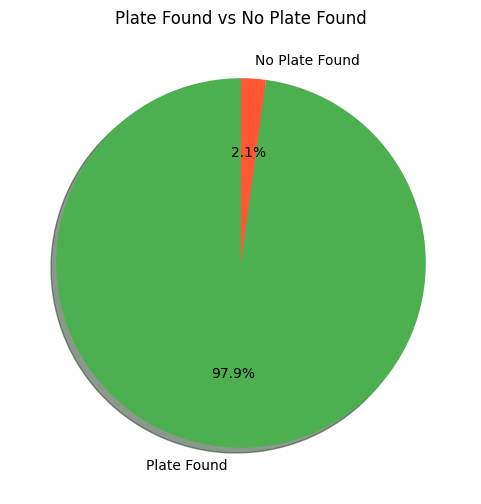

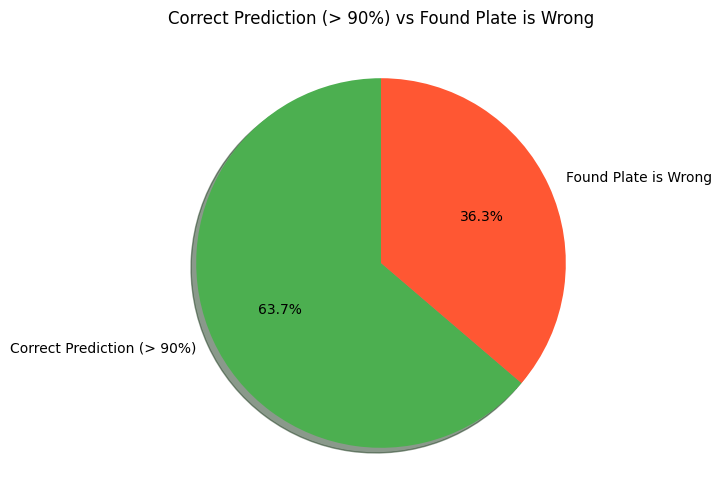

Count 1: 43
Overall Mean: 82.30035860462503
Overall Count: 866
Correctness_score_above_zero:  84.10602467100837
Correctness score above 1: 1.0
Overall Correct:  0.9785310734463277
[  0.          71.76572419  90.91764706  94.55375346  84.49359303
  92.3633281   96.02334815  98.57924171  87.66022039  97.42935882
  99.63571611   1.          77.10902641   1.          94.40613027
  91.25353666  95.57441816  95.71780235  78.83098174  74.65550778
   1.           0.          93.96897415  92.94730459  99.86413043
  69.30387793   1.          94.50047719  94.96883541 100.
  82.65078183  74.9075758   70.16902133  96.49664996  88.58935151
  96.52002423  91.06375861  94.59755856  94.29498058  90.82083647
  95.49652635  97.296792    72.12088024  93.08677095  97.23204666
 100.          98.37695395  95.10957967  95.97965485  94.12660327
  98.929711    98.64136631  99.53014816  98.79096191  76.94716719
  95.27458967  94.80499512  94.10907693 100.          97.16366612
  92.60695577  95.9136273   91.78746

In [95]:
preprocess_images("val")
# ohne anpassung der green box

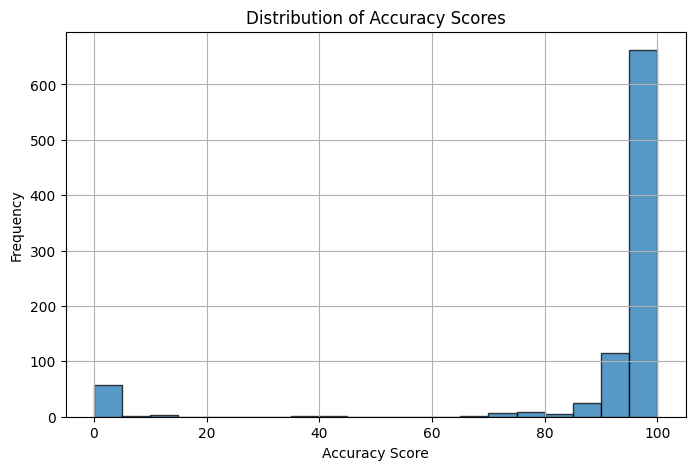

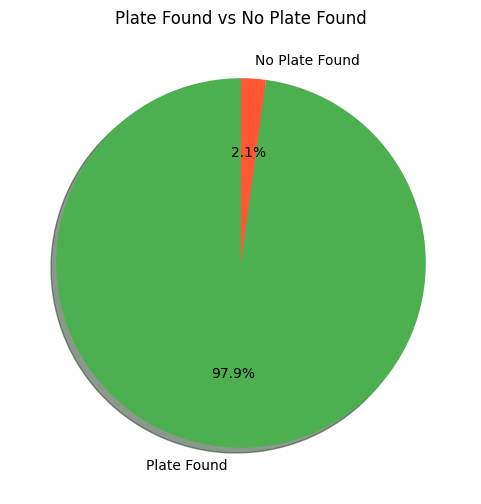

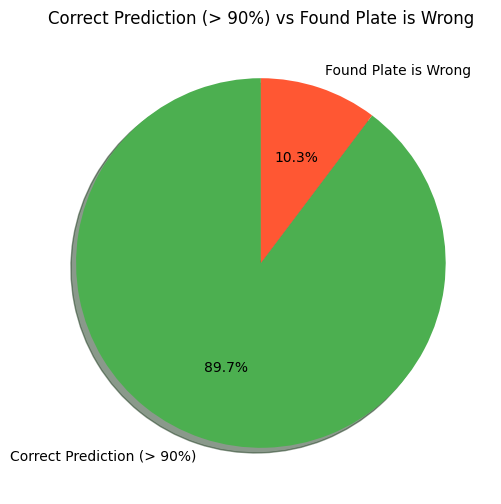

Count 1: 38
Overall Mean: 91.03551939268772
Overall Count: 866
Correctness_score_above_zero:  93.03283448328942
Correctness score above 1: 0.998792270531401
Overall Correct:  0.9785310734463277
[  0.          91.72077922 100.         100.          98.85204082
 100.         100.         100.          99.86702128 100.
 100.           1.          93.92097264   1.         100.
 100.         100.         100.          99.59718026  93.37175793
   0.3996004    0.          99.96871089  99.87745098 100.
  85.8974359   10.1010101  100.         100.         100.
  99.36507937  97.00598802  87.36702128 100.          99.84139572
 100.         100.         100.          99.97403946 100.
 100.         100.          90.26548673  99.95408632 100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.          95.26143791
  99.9738767  100.         100.         100.         100.
  99.8008464  100.         100.          89.87995894 100.
 100.         100.  

In [93]:
preprocess_images("val")
# mit anpassung der green box

In [93]:
preprocess_images("train")

Overall Mean: 69.33291546613252
Overall Count: 7125
Correctness_score_above_zero:  70.52982053312664
Overall Correct:  0.9830298013245033
[ 1.         77.05579632 79.8245614  ... 82.02087287 78.79652445
 83.82449079]


In [83]:
preprocess_images("train")

Overall Mean: 76.57848399211406
Overall Count: 7125
Correctness_score_above_zero:  77.90047045260934
Overall Correct:  0.9830298013245033
[ 1.         79.17659805 95.61403509 ... 85.61827957 85.83192841
 92.69480728]


In [80]:
preprocess_images("train")

Overall Mean: 73.7492773171247
Overall Count: 7125
Correctness_score_above_zero:  75.02242273607312
Overall Correct:  0.9830298013245033
[ 1.         74.19545162 94.72049689 ... 75.96899225 84.11163203
 92.43945621]


In [65]:
preprocess_images("train")

Overall Mean: 86.58587413120347
Overall Count: 7125
Correctness_score_above_zero:  88.08061974778484
Overall Correct:  0.9830298013245033
[  1.          91.86294766 100.         ...  94.09334986  91.67689752
  99.00497512]


In [66]:
preprocess_images("test")

Overall Mean: 85.46016881241964
Overall Count: 880
Correctness_score_above_zero:  87.20821771994635
Overall Correct:  0.9799554565701559
[ 99.04761905  96.77224256  79.83193277  95.78947368  85.32110092
 100.          87.32876712  20.48079018   1.          79.2920354
   1.          99.6124031   84.73026316   1.          96.24573379
  98.99665552  23.96802326  94.61363105  98.38187702  90.01126798
  91.85936015  21.07265765  84.68468468 100.         100.
 100.          14.64568705  59.81074481  20.93698544  97.30538922
  96.8168744   97.19899666  94.63917526  96.80851064  95.69892473
  92.91443044  98.03921569  95.70506539 100.          97.16981132
  32.00695803  96.84210526 100.          86.91588785 100.
 100.          98.45679012  91.75391608  98.02631579  89.62164447
   0.          98.65319865 100.          87.49792462  96.68674699
  67.66721763 100.          97.84172662  90.56603774   1.
  96.36363636   1.           1.          21.62922374  96.73913043
  99.11242604  95.28301887  85

In [67]:
preprocess_images("val")

Overall Mean: 87.01463706212067
Overall Count: 866
Correctness_score_above_zero:  88.92373418011175
Overall Correct:  0.9785310734463277
[  0.          91.48262169  95.61403509 100.         100.
  91.21404254 100.          98.54545455 100.          84.61538462
  77.05433318   1.         100.           1.         100.
 100.          85.4368932   94.39252336  65.2722063   85.29411765
   1.           0.         100.          97.64046     53.92587262
  98.87640449   1.          99.66101695  83.33090379  39.43766186
 100.          46.01233609  92.87454115  86.80770554  57.94536672
  97.97979798  96.65292096  80.68576389  95.57129945  79.19067709
 100.          78.90642932 100.          91.41501688  95.99478147
  44.68475287  98.19494585  85.41114058 100.          96.3963964
  93.4512987  100.          95.53571429  89.25804575  94.32801461
  92.55319149  97.39130435  95.23809524  68.13412409  97.95221843
  96.69421488 100.          99.37106918 100.          99.35483871
  70.82326962  54.5629

In [71]:
print("Train: ")
preprocess_images("train")

print("Test: ")
preprocess_images("test")

print("Val: ")
preprocess_images("val")

Train: 
Overall Mean: 86.58587413120347
Overall Count: 7125
Correctness_score_above_zero:  88.08061974778484
Overall Correct:  0.9830298013245033
[  1.          91.86294766 100.         ...  94.09334986  91.67689752
  99.00497512]
Test: 
Overall Mean: 85.46016881241964
Overall Count: 880
Correctness_score_above_zero:  87.20821771994635
Overall Correct:  0.9799554565701559
[ 99.04761905  96.77224256  79.83193277  95.78947368  85.32110092
 100.          87.32876712  20.48079018   1.          79.2920354
   1.          99.6124031   84.73026316   1.          96.24573379
  98.99665552  23.96802326  94.61363105  98.38187702  90.01126798
  91.85936015  21.07265765  84.68468468 100.         100.
 100.          14.64568705  59.81074481  20.93698544  97.30538922
  96.8168744   97.19899666  94.63917526  96.80851064  95.69892473
  92.91443044  98.03921569  95.70506539 100.          97.16981132
  32.00695803  96.84210526 100.          86.91588785 100.
 100.          98.45679012  91.75391608  98.0263